In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import circulant

In [81]:
# win=sinc_hamming(4,4096)
# win
ndat=5000
mat=circulant(np.hstack([[1.5,2.3,2.3,1.5],np.zeros(ndat-4)])).T
x=np.random.randint(0,100,ndat)

In [82]:
yf=mat[:-3]@x

In [83]:
ynew=np.append(yf,yf[:3])

In [84]:
matinv=np.linalg.inv(mat)

In [85]:
xrecons=matinv@ynew

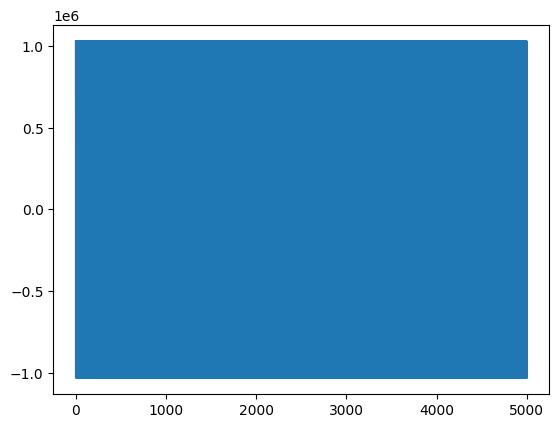

In [86]:
plt.plot(x-xrecons)

In [120]:
win=sinc_hamming(4,4096)
win=win.reshape(4,-1)
ndat=4096*10
mat=np.zeros((ndat,4096))
mat[:4,:]=win

In [121]:
eigvals=np.fft.rfft(mat,axis=0)

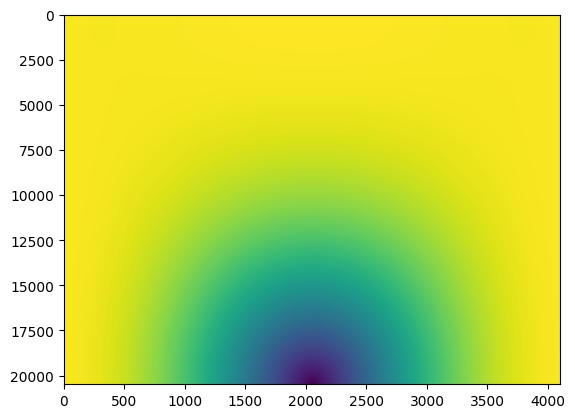

In [135]:
plt.imshow(np.abs(eigvals),aspect='auto',interpolation='none')

In [144]:
win

array([[-3.11853747e-18, -9.76682041e-06, -1.95360449e-05, ...,
        -3.94862922e-04, -2.63392414e-04, -1.31771451e-04],
       [ 2.10518472e-17,  1.31921971e-04,  2.63994494e-04, ...,
         9.99998906e-01,  9.99999532e-01,  9.99999893e-01],
       [ 9.99999992e-01,  9.99999826e-01,  9.99999396e-01, ...,
         3.96088296e-04,  2.63908310e-04,  1.31878889e-04],
       [ 2.10449701e-17, -1.31728390e-04, -2.63306314e-04, ...,
        -2.93076315e-05, -1.95360201e-05, -9.76681628e-06]])

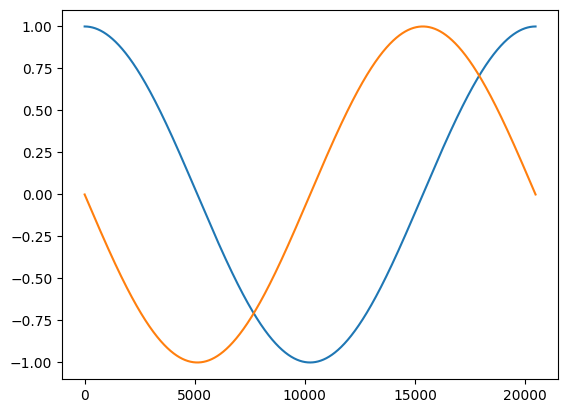

In [142]:
plt.plot(np.real(eigvals[:,0]))
plt.plot(np.imag(eigvals[:,0]))

In [128]:
err_mat=np.tile(np.sinc(3*np.pi*np.arange(ndat//2+1)/N),4096).reshape(4096,-1).T

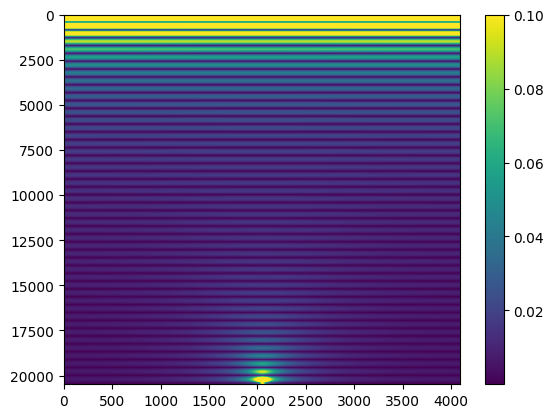

In [134]:
plt.imshow(np.abs(err_mat)/np.abs(eigvals),aspect='auto',vmax=0.1)
plt.colorbar()

In [145]:
new_mat = np.fft.irfft(err_mat/eigvals,axis=0)

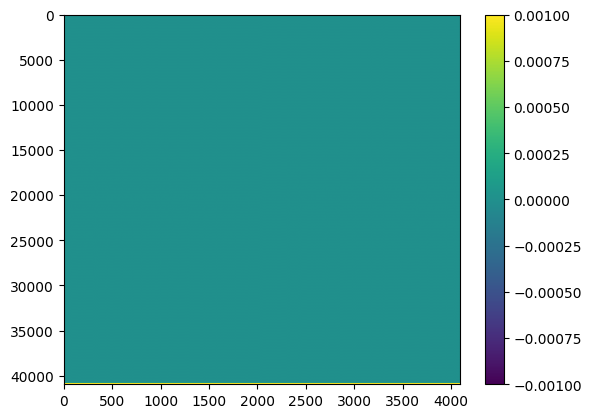

In [147]:
plt.imshow(new_mat,aspect='auto',vmax=0.001,vmin=-0.001)
plt.colorbar()

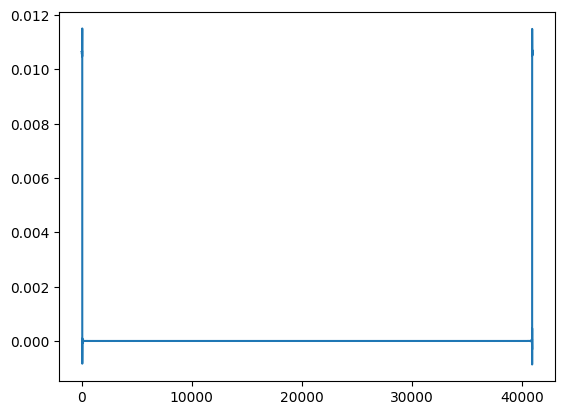

In [150]:
plt.plot(new_mat[:,20])

(20380.0, 20580.0)

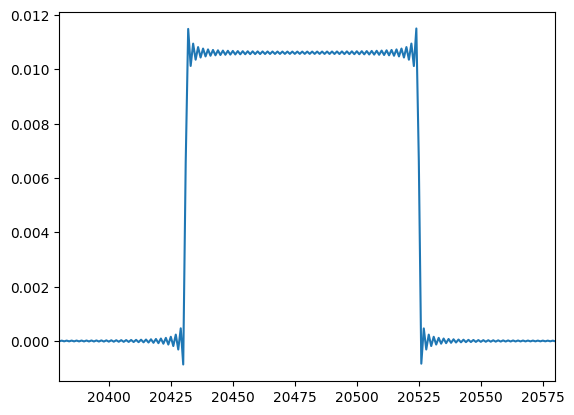

In [152]:
plt.plot(np.fft.fftshift(new_mat[:,20]))
plt.xlim(ndat//2-100,ndat//2+100)

In [103]:
np.abs(eigvals)[-1,2048]

0.0001058883366843455

In [104]:
win=sinc_hamming(4,4096)

In [106]:
N=4096

In [109]:
win[N//2::N]

array([-0.04557062,  0.55087721,  0.55079779, -0.04554415])

In [111]:
win=sinc(4,4096)
win[N//2::N]

array([-0.21220659,  0.63661977,  0.63661977, -0.21220659])

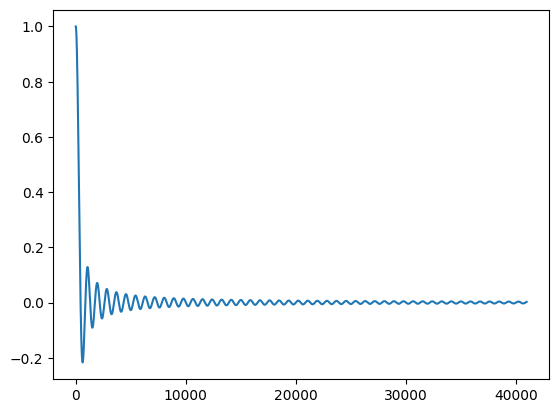

In [114]:
k=np.arange(10*N)
plt.plot(np.sinc(3*np.pi*k/N))

In [110]:
def ipfb(inft,win,ntap,thresh=0):
    in_unft=np.fft.irfft(inft,axis=1)
    n=in_unft.shape[1]
    winmat=np.zeros(in_unft.shape)
    winmat[:ntap,:]=np.reshape(win,[ntap,n])
    winft=np.fft.rfft(winmat,axis=0)
    myft=np.fft.rfft(in_unft,axis=0)
    if thresh>0:
        filt=np.abs(winft)**2/(thresh**2+np.abs(winft)**2)*(1+thresh**2)
        myft=myft*filt
    out=np.fft.irfft(myft/np.conj(winft),axis=0)
    return out
def sinc_hamming(ntap,lblock):
    N=ntap*lblock
    w=np.arange(0,N)-N/2
    return np.hamming(ntap*lblock)*np.sinc(w/lblock)

def sinc_hanning(ntap,lblock):
    N=ntap*lblock
    w=np.arange(0,N)-N/2
    return np.hanning(ntap*lblock)*np.sinc(w/lblock)

def sinc(ntap,lblock):
    N=ntap*lblock
    w=np.arange(0,N)-N/2
    return np.sinc(w/lblock)

def pfb(timestream, nchan=2048, ntap=4, window=sinc_hanning):

    # number of samples in a sub block
    lblock = 2*(nchan-1)
    # number of blocks
    nblock = timestream.size / lblock - (ntap - 1)
    if nblock==int(nblock): nblock=int(nblock)
    else: raise Exception("nblock is {}, should be integer".format(nblock))

    # initialize array for spectrum 
    spec = np.zeros((nblock,nchan), dtype=np.complex128)

    # window function
    w = window(ntap, lblock)

    def s(ts_sec):
        return np.sum(ts_sec.reshape(ntap,lblock),axis=0) # this is equivalent to sampling an ntap*lblock long fft - M


    # iterate over blocks and perform PFB
    for bi in range(nblock):
        # cut out the correct timestream section
        ts_sec = timestream[bi*lblock:(bi+ntap)*lblock].copy()

        spec[bi] = np.fft.rfft(s(ts_sec * w)) 

    return spec

In [6]:
ntap=4
nchan=2049
nslice=32*1024 # Mohan: this is num of pfb spectra
nn=2*(nchan-1)
x=np.random.randn(nslice+ntap-1,nn)
xx=np.ravel(x)
dwin=sinc_hamming(ntap,nn)
dxpfb=pfb(xx,nchan,ntap,sinc_hamming)

In [7]:
dxpfb.shape

(32768, 2049)

In [47]:
out=ipfb(dxpfb,dwin,ntap,thresh=0.01)

In [9]:
to_cut=50
imax=out.shape[0]-to_cut

In [48]:
err=np.ravel(out[to_cut:imax,:]-x[to_cut:imax,:])
np.std(err)

0.004909573037024686

Text(0.5, 1.0, 'thresh=0.1')

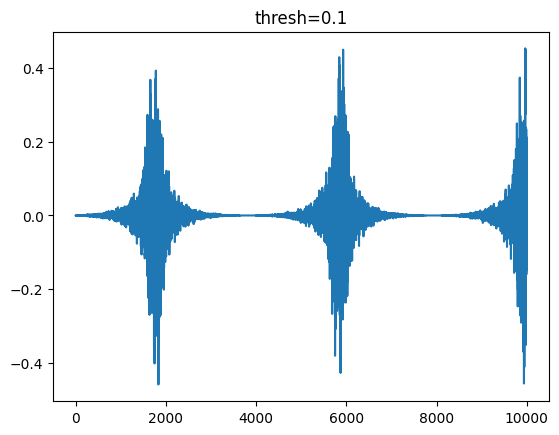

In [46]:
s=500000
ds=10000
plt.plot(err[s:s+ds])
plt.title("thresh=0.1")
# plt.xlim(0,100)

Text(0.5, 1.0, 'thresh=0.01')

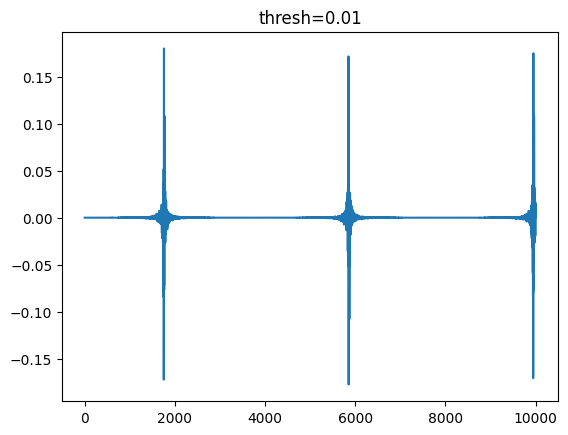

In [49]:
s=500000
ds=10000
plt.plot(err[s:s+ds])
plt.title("thresh=0.01")
# plt.xlim(0,100)

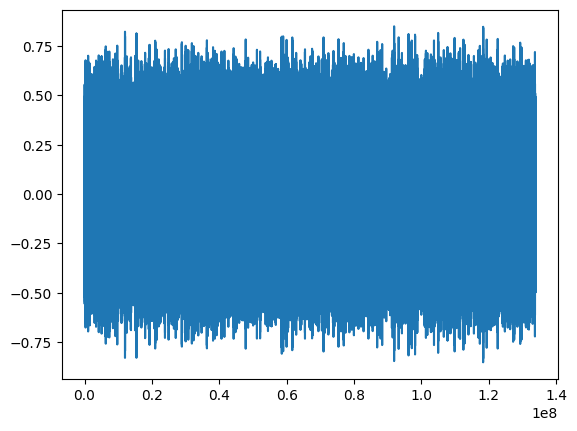

In [27]:
plt.plot(err)

In [51]:
errft=np.fft.rfft(err)
ps=np.abs(errft)
# plt.plot(ps)

KeyboardInterrupt: 